# Variational Autoencoders

Forcing the $z$ distribution to be what we wish.

<img src="images/vae.png" width="500"/>
<img src="images/normal.webp" width="100"/>
<center>Danijar Hafner, <a href="https://danijar.com/building-variational-auto-encoders-in-tensorflow/">Building Variational Auto-Encoders in TensorFlow</a>.</center>

## Problem definition

> Given the visible variables $x$, estimate $z$.

As a conditional probability:

$$\Large
p(z|x) = \frac{p(x|z)p(z)}{p(x)} = \frac{p(x|z)p(z)}{\int p(x|z)p(z)dz}
$$

Unfortunately, _$p(x)$ is untractable_.

Two main approaches:

- __Monte-Carlo methods__: Gibbs sampling as an MCMC method.
- __Variational inference__: the VAEs are one example of this approach.

## Solution plan

Solution: __do not study__ $\large p(z|x)$, instead:

- choose another (tractable) distribution $q(z|x)$;
- make $q(z|x)$ as close as possible to $p(z|x)$;
- approximate using $q$ instead of $p$.

### Making the two distributions similar

__Adapt the parameters of $q$ so that a measure of "distance" between the distributions is minimized.__

Kullback-Leibler divergence between q and p: __difference of cross-entropies wrt $q$__:

\begin{eqnarray}
\large KL(q||p) 
    &=&  \large -H[q,q] + H[q,p] 
    = \large \mathbb{E}_q \log q(x) - \mathbb{E}_q \log p(x) \\
    &=&  \large \sum q(x) \log q(x) - \sum q(x) \log p(x) \\
    &=&  \large \sum q(x) \log\left(\frac{q(x)}{p(x)}\right) 
    = -\large \sum q(x) \log\left(\frac{p(x)}{q(x)}\right) \\
\end{eqnarray}

### The variational lower-bound

> __Our task is to estimate $p(x)$, or equivalently $\log p(x)$.__

Consider the following derivation starting from __log evidence__:

$$\Large
\begin{eqnarray}
\log p(x) &=& \log\int_z p(x,z)dz \\
          &=& \log\int_z p(x,z)\frac{q(z|x)}{q(z|x)}dz 
          = \log\int_z q(z|x)\frac{p(x,z)}{q(z|x)}dz \\
          &=& \log\mathbb{E}_{q(z|x)} \left[\frac{p(x,z)}{q(z|x)}\right] \\
\end{eqnarray}
$$

__Jensen's inequality__:

> For every convex function $\psi$ it is
$\Large\psi(\mathbb{E}[x]) \geq \mathbb{E}[\psi(x)]$

applying it to the last derivation:

$$\Large
\begin{eqnarray}
\log p(x) &\geq& \mathbb{E}_{q(z|x)} \left[\log\frac{p(x,z)}{q(z|x)}\right] \\
          &=& \mathbb{E}_{q(z|x)} \left[\log\frac{p(x|z)p(z)}{q(z|x)}\right] \\
          &=& \mathbb{E}_{q(z|x)} \left[\log p(x|z)\right] + \mathbb{E}_{q(z|x)} \left[\log\frac{p(z)}{q(z|x)}\right] \\
          &=& \mathbb{E}_{q(z|x)} \left[\log p(x|z)\right] - KL\left(q(z|x)\|p(z)\right) \\
\end{eqnarray}
$$

that is:

$$\Large
\log p(x) \geq \mathcal{L}(x) = \text{log likelihood} - \text{KL divergence}
$$

The following quantity is called __variational lower-bound__ or __evidence lower-bound__ (ELBO):

$$\Large
\mathcal{L}(x) = \mathbb{E}_{q(z|x)} \left[\log\frac{p(x,z)}{q(z|x)}\right]
$$

Notice that __maximizing $\Large\mathcal{L}(\hat{x})$__ we get:

- __$\Large\mathbb{E}_{q(z|x)} \left[\log p(x|z)\right]$ maximized__, representing the log-likelihood of data;
- __$\Large KL(q(z|x)||p(z))$ minimized__, representing distribution adherence.

## Amortized ELBO maximization

The optimal inference can be obtained maximizing $\large\arg\max_\theta\mathcal{L}_\theta(x)$ on a per $x$ basis.

In amortized inference instead we maximize $\large\arg\max_\theta\mathbb{E}_{p(x)}\left[\mathcal{L}_\theta(x)\right]$ working on the whole dataset simultaneously.

This introduces an approximation faced in works such as ["Amortized Inference Regularization"](https://proceedings.neurips.cc/paper/2018/file/1819932ff5cf474f4f19e7c7024640c2-Paper.pdf) (Stanford University).

## From the theory to the practice

> Assume __$\Large p(z)$ standard normal__,  

> we choose __$\Large q(z|x)$ gaussian__ with diagonal covariance (why?).

### What will we use as log likelihood?

If by hypothesis $p(\hat{x}|z)\sim\mathcal{N}(x;\hat{x}(z),I)$, then maximizing:

$$\Large
\begin{eqnarray}
\mathbb{E}_{q(z|x)} \log p(\hat{x}|z)
&=& - c \cdot \mathbb{E}_{q(z|x)} \|x-\hat{x}\|^2 \\
\end{eqnarray}
$$

corresponds to __minimize the MSE__.

### How can we compute the $KL$?

In the gaussian case, following the passages reported [here](https://arxiv.org/pdf/1907.08956.pdf) (pages 5-7), we get eq. 40 stating that:

$$\Large
- KL\left(q(z|x)\|p(z)\right) = \frac{1}{2}
    \sum_i \left[
        1 + \log \sigma_i^2 - \sigma_i^2 - \mu_i^2
    \right]
$$

where $\mu_i$ and $\sigma_i$ address the $q(z|x)$ means and variances.

### How can we compute the expectation over $q$?

One answer: __by sampling!__

Consider the DNN:

<img src="images/vae_gaussian.png" width="750"/>
<center>Lilian Weng, "From Autoencoder to Beta-VAE"</center>

- The encoder estimates $q(z|x)$;
- the reparameterization trick allows to sample from it;
- the decoder allows to estimate $\hat{x}$ given $z$ (that is $p(\hat{x}|z)$).

At the reparameterization level for every $x$ we can draw many samples.

NOTE: Given that the batch is __large enough__, just one sample per $x$ can be sufficiente to allow likelihood maximization.

## Geometrical interpretation of the loss

The final loss to be minimized is:

$$\Large
\sum \|x - \hat{x}\|^2 -
\frac{1}{2}
\sum \left[
    1 + \log \sigma_i^2 - \sigma_i^2 - \mu_i^2
\right]
$$

Notice that:

- __the encoder maps ponts $x$ in gaussian distributions__ (latent space regions);
- forcing the similarity with the MSE spreads the regions (repulsive force);
- the function $-(1 + \log \sigma_i^2 - \sigma_i^2)$ is minimized near $0.45$
  (variances do not tend to collapse);
- minimizing the quantity $\mu_i^2$ keeps the means close to zero (compaction force).

<img src="images/vae_forces.png" width="500"/>

In [1]:
# Just to work comfortably with py files:
%load_ext autoreload
%autoreload 2

In [10]:
from dataset import load_mnist, PairDataset
from vae import VariationalAutoencoder
from modules import num_params

train_ds = PairDataset(load_mnist(train=True)[0])
test_ds = PairDataset(load_mnist(train=False)[0])

vae = VariationalAutoencoder(dim=8)
t_in = train_ds[0:1,None,:,:][0]
t_out, t_mu, t_logvar = vae(t_in)

print(f"VAE:\n\tshapes: {tuple(t_in.shape)} => {tuple(t_out.shape)}")
print(f"\ttheta:\n\t\tmu: {tuple(t_mu.shape)}")
print(f"\t\tlogvar: {tuple(t_logvar.shape)}")
print(f"\tparameters: {num_params(vae)}")

VAE:
	shapes: (1, 1, 28, 28) => (1, 1, 28, 28)
	theta:
		mu: (1, 8)
		logvar: (1, 8)
	parameters: 15349


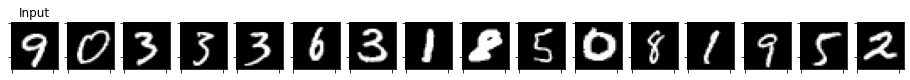

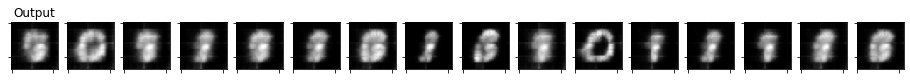

train_mse[1] = 0.09750347240491117
train_kld[1] = 2093.4120342376386
train_loss[1] = 0.09959688429185684
test_mse[1] = 0.05879864012822509
test_kld[1] = 2323.9324241638183
test_loss[1] = 0.06112257270142436



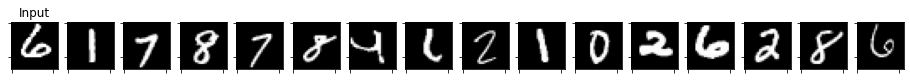

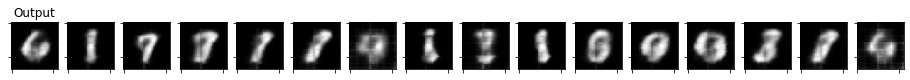

train_mse[2] = 0.050917612333247
train_kld[2] = 2913.1472827667885
train_loss[2] = 0.05383075962358333
test_mse[2] = 0.04410230275243521
test_kld[2] = 3459.299649429321
test_loss[2] = 0.04756160248070955



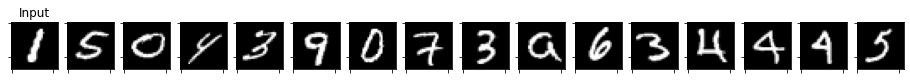

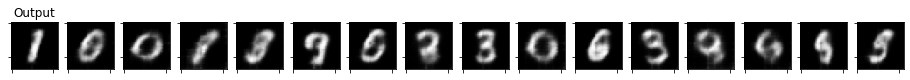

train_mse[3] = 0.040878916880551806
train_kld[3] = 3675.156513360206
train_loss[3] = 0.04455407334769026
test_mse[3] = 0.037728419061750174
test_kld[3] = 3855.4954837799073
test_loss[3] = 0.041583914496004584



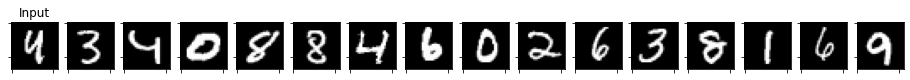

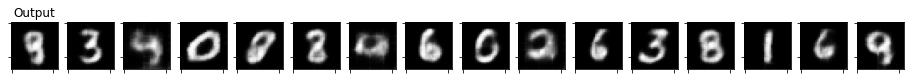

train_mse[4] = 0.03611985287292207
train_kld[4] = 3961.3058988530584
train_loss[4] = 0.04008115881935079
test_mse[4] = 0.03393400963395834
test_kld[4] = 4112.500712585449
test_loss[4] = 0.03804651061072946



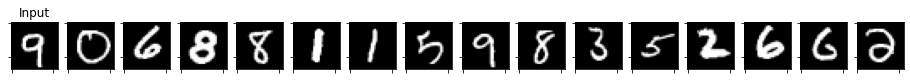

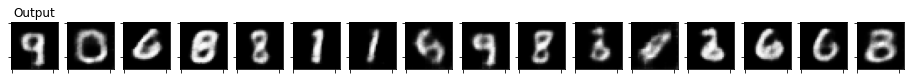

train_mse[5] = 0.0332020215531613
train_kld[5] = 4141.420033036901
train_loss[5] = 0.037343441544378055
test_mse[5] = 0.03168245130218565
test_kld[5] = 4287.52783279419
test_loss[5] = 0.03596997899003327



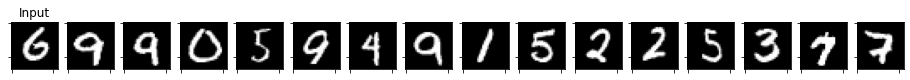

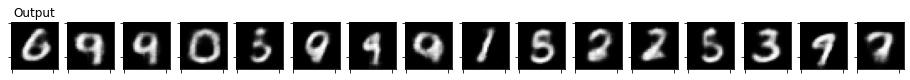

train_mse[6] = 0.03149009792411581
train_kld[6] = 4246.745407559009
train_loss[6] = 0.03573684334120852
test_mse[6] = 0.030386015539988875
test_kld[6] = 4338.110517120362
test_loss[6] = 0.034724125918000934



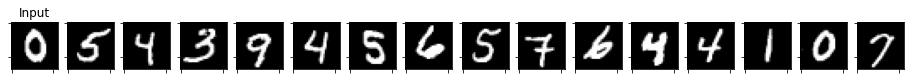

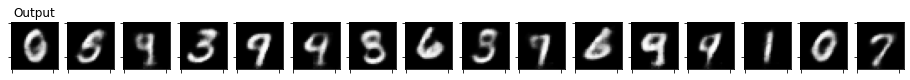

train_mse[7] = 0.030286186695732967
train_kld[7] = 4321.118006669714
train_loss[7] = 0.03460730480703902
test_mse[7] = 0.029410078004002572
test_kld[7] = 4369.808213043213
test_loss[7] = 0.03377988622523844



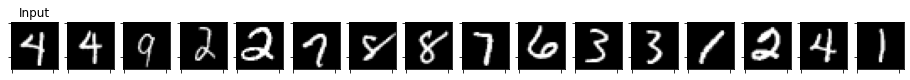

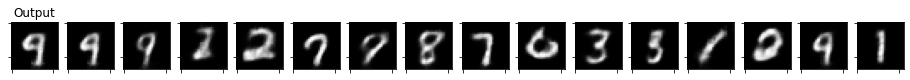

train_mse[8] = 0.029353940344237266
train_kld[8] = 4361.593556245844
train_loss[8] = 0.0337155338297499
test_mse[8] = 0.02831149655394256
test_kld[8] = 4337.3611686706545
test_loss[8] = 0.032648857682943344



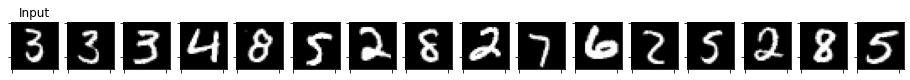

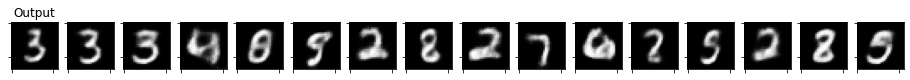

train_mse[9] = 0.02864120052532947
train_kld[9] = 4399.1203592503325
train_loss[9] = 0.03304032088118665
test_mse[9] = 0.027900805603712796
test_kld[9] = 4467.129126739502
test_loss[9] = 0.032367934752255675



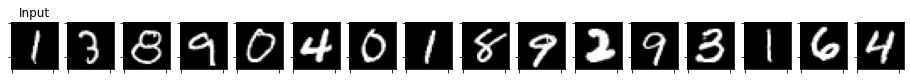

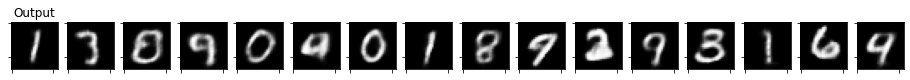

train_mse[10] = 0.028084083289859143
train_kld[10] = 4422.333114818816
train_loss[10] = 0.03250641634965196
test_mse[10] = 0.027606287878006695
test_kld[10] = 4489.843235015869
test_loss[10] = 0.03209613114595413



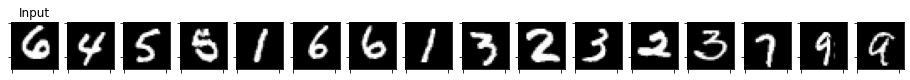

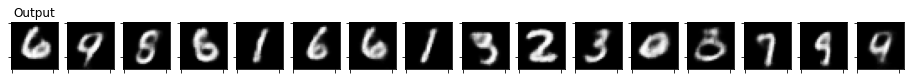

train_mse[11] = 0.027605942906217373
train_kld[11] = 4458.04453125
train_loss[11] = 0.032063987486540005
test_mse[11] = 0.02732576630078256
test_kld[11] = 4444.577374267578
test_loss[11] = 0.03177034384571016



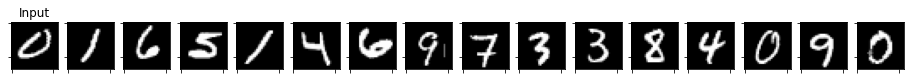

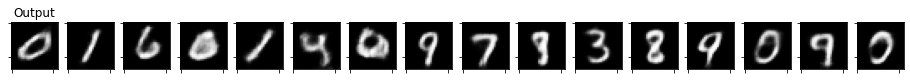

train_mse[12] = 0.027165827242300867
train_kld[12] = 4467.442588513963
train_loss[12] = 0.03163326981853932
test_mse[12] = 0.026832708483561875
test_kld[12] = 4430.224054718017
test_loss[12] = 0.031262932484969495



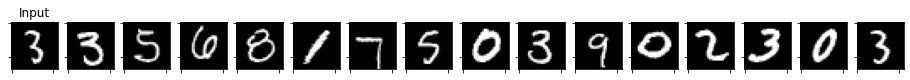

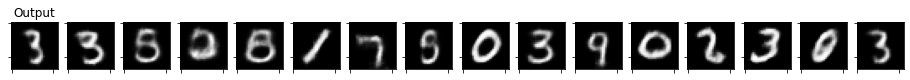

train_mse[13] = 0.026790790608588685
train_kld[13] = 4489.879958651928
train_loss[13] = 0.031280670552811723
test_mse[13] = 0.026270525064319372
test_kld[13] = 4461.41817703247
test_loss[13] = 0.030731943296268584



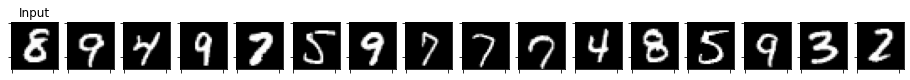

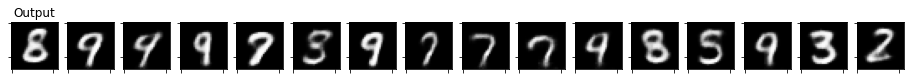

train_mse[14] = 0.02643284911805011
train_kld[14] = 4509.032710688165
train_loss[14] = 0.030941881754613938
test_mse[14] = 0.02591301635839045
test_kld[14] = 4477.484391021729
test_loss[14] = 0.03039050064980984



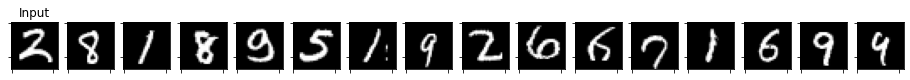

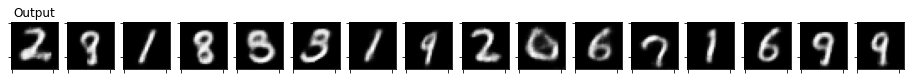

train_mse[15] = 0.026118822784182875
train_kld[15] = 4520.325266996343
train_loss[15] = 0.030639147996268375
test_mse[15] = 0.02579076886177063
test_kld[15] = 4423.860157775879
test_loss[15] = 0.030214629089459776



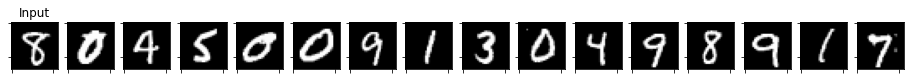

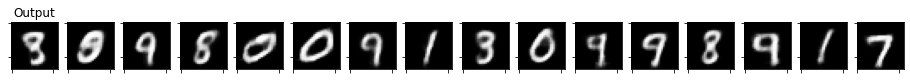

train_mse[16] = 0.025897523047442132
train_kld[16] = 4532.107229159741
train_loss[16] = 0.030429630266859176
test_mse[16] = 0.02541474364697933
test_kld[16] = 4574.858553314209
test_loss[16] = 0.029989602230489253



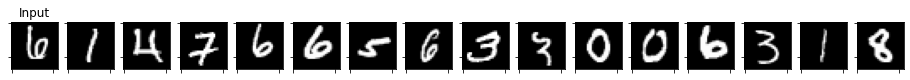

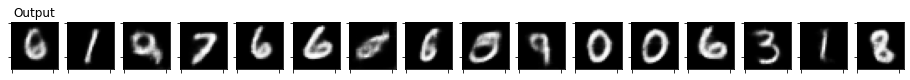

train_mse[17] = 0.025670287845299598
train_kld[17] = 4529.961468895445
train_loss[17] = 0.03020024929750473
test_mse[17] = 0.024964046152308583
test_kld[17] = 4597.997895812989
test_loss[17] = 0.029562044097110628



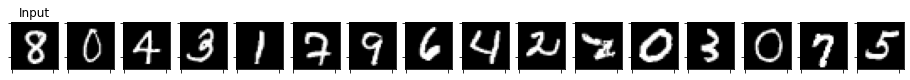

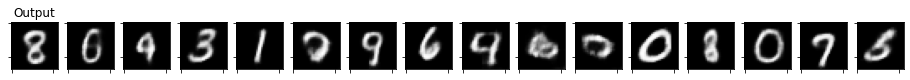

train_mse[18] = 0.025430124641415922
train_kld[18] = 4541.924154857879
train_loss[18] = 0.029972048904350464
test_mse[18] = 0.025026684161275625
test_kld[18] = 4577.713764190674
test_loss[18] = 0.029604397853836416



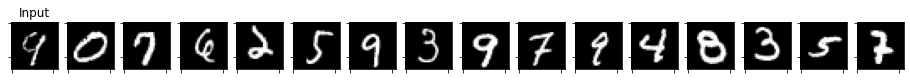

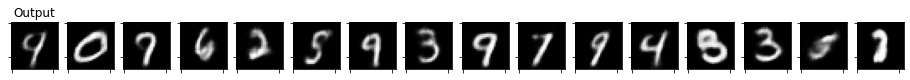

train_mse[19] = 0.025237364512174686
train_kld[19] = 4547.473933572972
train_loss[19] = 0.029784838427254493
test_mse[19] = 0.0247760065831244
test_kld[19] = 4519.954870605468
test_loss[19] = 0.029295961698517205



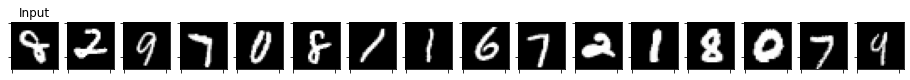

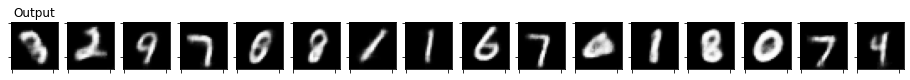

train_mse[20] = 0.02504937326971521
train_kld[20] = 4551.689106133644
train_loss[20] = 0.029601062382472322
test_mse[20] = 0.02460291306488216
test_kld[20] = 4536.7084312438965
test_loss[20] = 0.02913962132297456



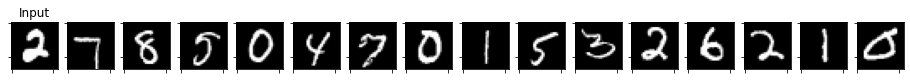

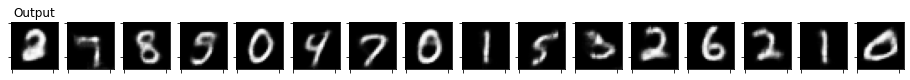

train_mse[21] = 0.024906966272503772
train_kld[21] = 4550.289141975565
train_loss[21] = 0.029457255437019023
test_mse[21] = 0.02429853193461895
test_kld[21] = 4590.051734924316
test_loss[21] = 0.028888583462685347



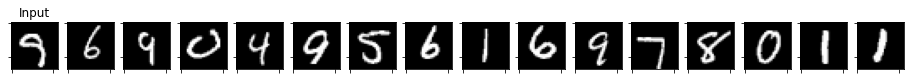

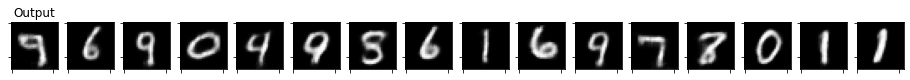

train_mse[22] = 0.024749343231954473
train_kld[22] = 4559.730206948138
train_loss[22] = 0.029309073383820817
test_mse[22] = 0.02432888583280146
test_kld[22] = 4519.9063720703125
test_loss[22] = 0.028848792240023614



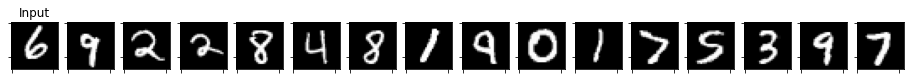

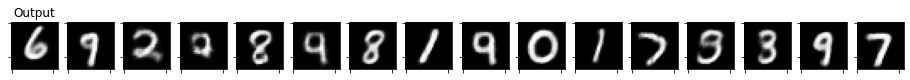

train_mse[23] = 0.024586260493131395
train_kld[23] = 4567.750621779422
train_loss[23] = 0.029154011076118085
test_mse[23] = 0.024086479842662812
test_kld[23] = 4548.0081787109375
test_loss[23] = 0.028634488023817538



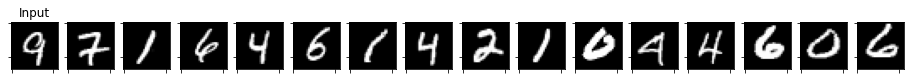

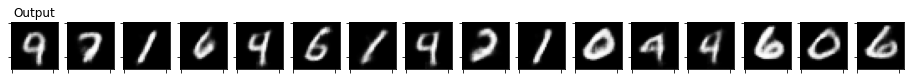

train_mse[24] = 0.02445600261079504
train_kld[24] = 4565.8650723071805
train_loss[24] = 0.02902186767376484
test_mse[24] = 0.02394264144822955
test_kld[24] = 4622.268458557129
test_loss[24] = 0.02856490993872285



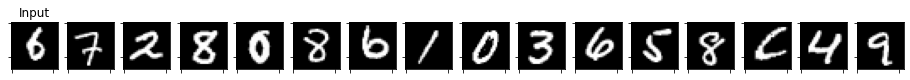

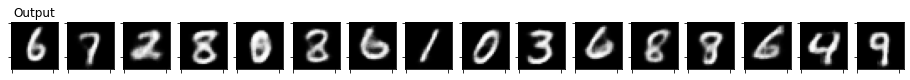

train_mse[25] = 0.024326177393185332
train_kld[25] = 4573.329411153591
train_loss[25] = 0.02889950678069541
test_mse[25] = 0.02395210466347635
test_kld[25] = 4578.674792480469
test_loss[25] = 0.028530779527500272



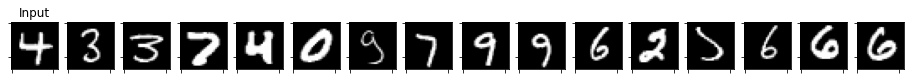

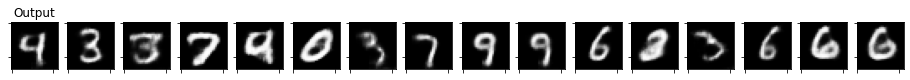

train_mse[26] = 0.024176826034771635
train_kld[26] = 4574.5805643284575
train_loss[26] = 0.028751406533286925
test_mse[26] = 0.02380081359297037
test_kld[26] = 4550.5689895629885
test_loss[26] = 0.02835138258524239



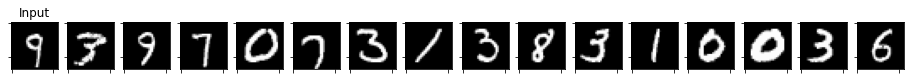

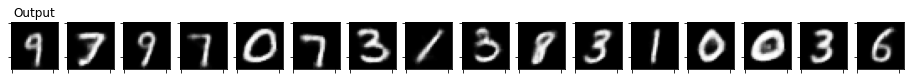

train_mse[27] = 0.024075588298604844
train_kld[27] = 4575.188310339096
train_loss[27] = 0.028650776582195402
test_mse[27] = 0.02362887393683195
test_kld[27] = 4499.963836669922
test_loss[27] = 0.028128837840631603



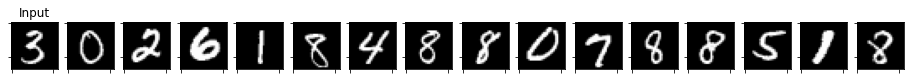

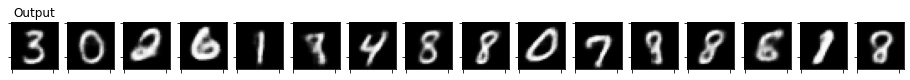

train_mse[28] = 0.023971448442403308
train_kld[28] = 4583.239625581782
train_loss[28] = 0.028554688092875986
test_mse[28] = 0.023577040107920767
test_kld[28] = 4500.199170684815
test_loss[28] = 0.02807723917067051



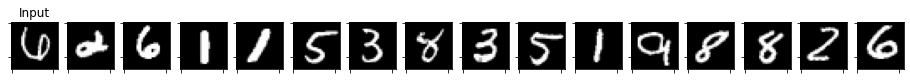

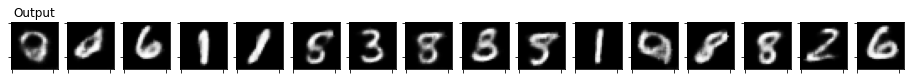

train_mse[29] = 0.023880373218909224
train_kld[29] = 4577.732292532413
train_loss[29] = 0.028458105495318454
test_mse[29] = 0.023392555071040988
test_kld[29] = 4558.525605773926
test_loss[29] = 0.027951080771163105



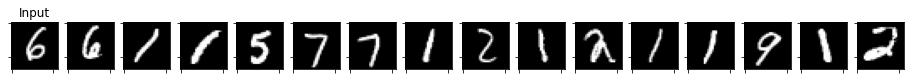

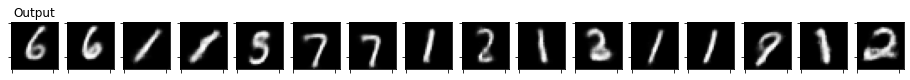

train_mse[30] = 0.023748608488351742
train_kld[30] = 4577.446154525433
train_loss[30] = 0.028326054599056853
test_mse[30] = 0.023535913275554775
test_kld[30] = 4531.720024108887
test_loss[30] = 0.028067633137106897



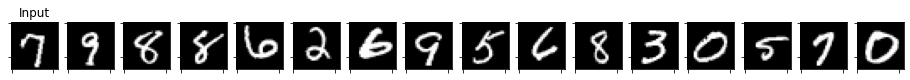

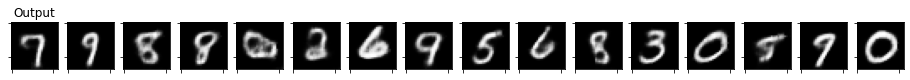

train_mse[31] = 0.023659090761174548
train_kld[31] = 4581.895928565492
train_loss[31] = 0.028240986715288872
test_mse[31] = 0.023376151593402027
test_kld[31] = 4517.397631835937
test_loss[31] = 0.027893549297004938



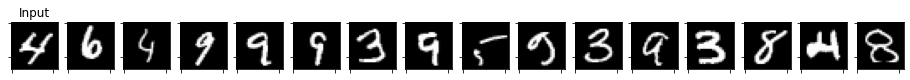

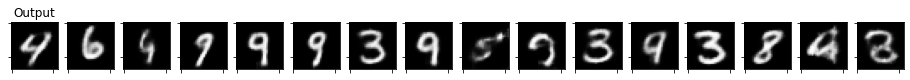

train_mse[32] = 0.023569240817364227
train_kld[32] = 4577.939475980718
train_loss[32] = 0.0281471802753971
test_mse[32] = 0.02319611762650311
test_kld[32] = 4585.466407775879
test_loss[32] = 0.0277815839741379



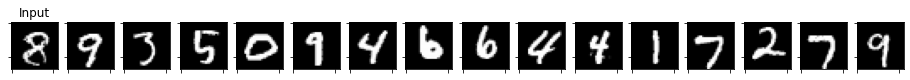

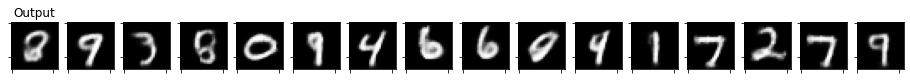

train_mse[33] = 0.023478151271317867
train_kld[33] = 4582.1922404837105
train_loss[33] = 0.028060343552460062
test_mse[33] = 0.023214039858430624
test_kld[33] = 4535.649439239502
test_loss[33] = 0.027749689249321818



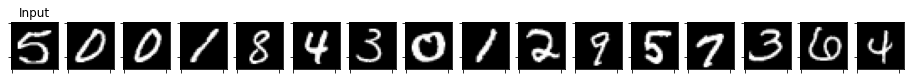

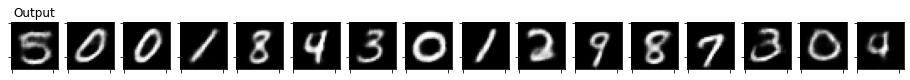

train_mse[34] = 0.023388176538208696
train_kld[34] = 4585.355420441323
train_loss[34] = 0.02797353189200797
test_mse[34] = 0.023152165627107025
test_kld[34] = 4569.332489013672
test_loss[34] = 0.027721498161554337



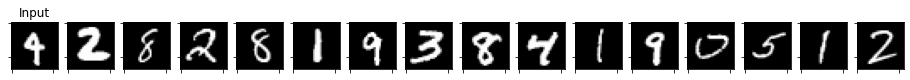

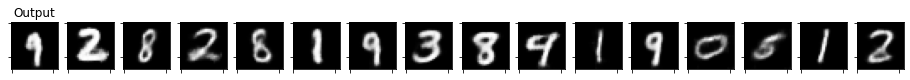

train_mse[35] = 0.02332204593781461
train_kld[35] = 4591.404879695811
train_loss[35] = 0.027913450861864902
test_mse[35] = 0.022883027466014026
test_kld[35] = 4586.799621582031
test_loss[35] = 0.02746982704848051



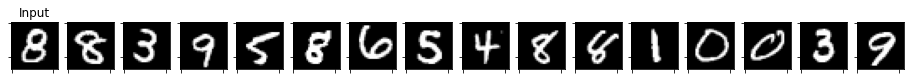

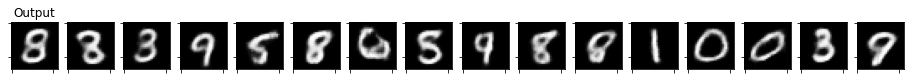

train_mse[36] = 0.02319624179855306
train_kld[36] = 4585.793602996177
train_loss[36] = 0.027782035349531376
test_mse[36] = 0.022783955140039325
test_kld[36] = 4572.37618484497
test_loss[36] = 0.02735633123666048



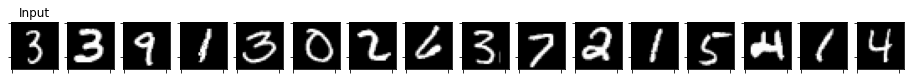

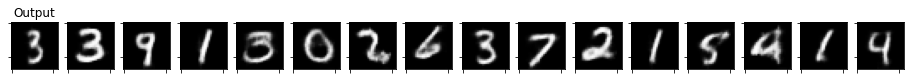

train_mse[37] = 0.02312910982427445
train_kld[37] = 4591.057108647773
train_loss[37] = 0.027720166909250808
test_mse[37] = 0.022920842003077268
test_kld[37] = 4463.504767608642
test_loss[37] = 0.027384346723556517



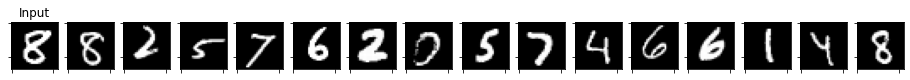

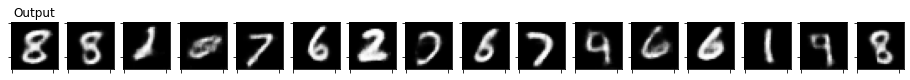

train_mse[38] = 0.023073327636465114
train_kld[38] = 4590.811658494016
train_loss[38] = 0.0276641392406631
test_mse[38] = 0.02272704113274813
test_kld[38] = 4543.944371032715
test_loss[38] = 0.027270985394716264



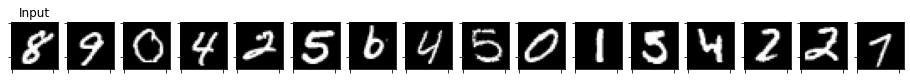

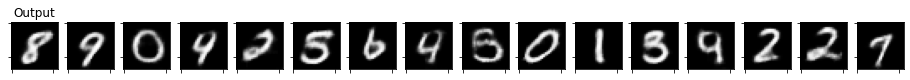

train_mse[39] = 0.02300129067549046
train_kld[39] = 4587.2277411278255
train_loss[39] = 0.02758851833641529
test_mse[39] = 0.022736675431951882
test_kld[39] = 4590.646101379394
test_loss[39] = 0.027327321702614427



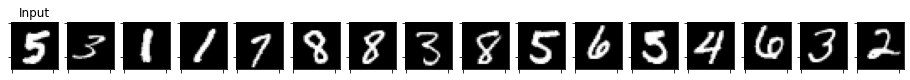

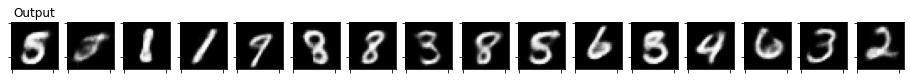

train_mse[40] = 0.022899290055353592
train_kld[40] = 4589.682930934176
train_loss[40] = 0.027488973023409538
test_mse[40] = 0.02260084021836519
test_kld[40] = 4505.692206573486
test_loss[40] = 0.027106532314792275



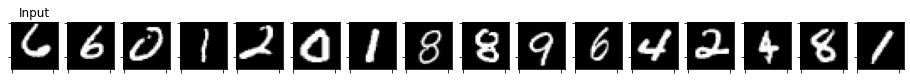

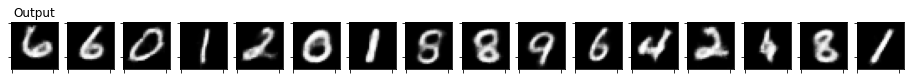

train_mse[41] = 0.02284280943902249
train_kld[41] = 4587.546627742686
train_loss[41] = 0.027430356040279914
test_mse[41] = 0.02252333555370569
test_kld[41] = 4486.531658172607
test_loss[41] = 0.027009867271408437



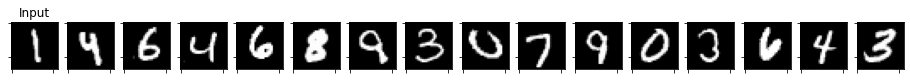

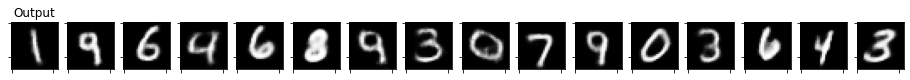

train_mse[42] = 0.022767031898206853
train_kld[42] = 4595.631831262467
train_loss[42] = 0.027362663734783518
test_mse[42] = 0.02223493647761643
test_kld[42] = 4626.77857131958
test_loss[42] = 0.02686171499080956



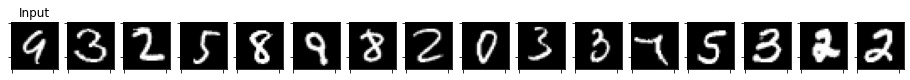

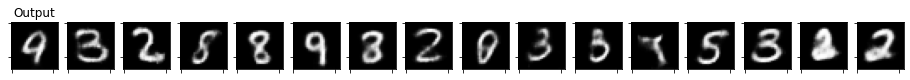

train_mse[43] = 0.022721385242457086
train_kld[43] = 4589.765699800532
train_loss[43] = 0.02731115091988381
test_mse[43] = 0.022338230442255736
test_kld[43] = 4615.736483764648
test_loss[43] = 0.026953966822475195



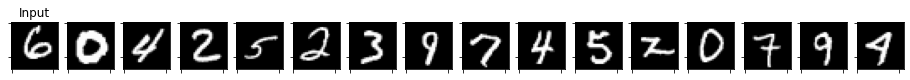

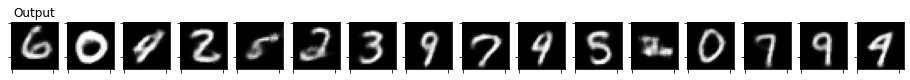

train_mse[44] = 0.022642357108440803
train_kld[44] = 4597.22754165974
train_loss[44] = 0.027239584637449143
test_mse[44] = 0.022398969065397976
test_kld[44] = 4587.032664489746
test_loss[44] = 0.02698600166477263



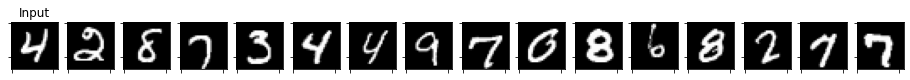

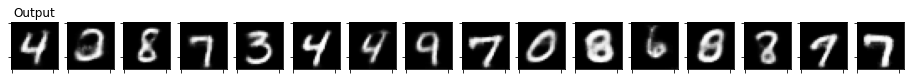

train_mse[45] = 0.022576468311091686
train_kld[45] = 4582.996355551862
train_loss[45] = 0.02715946464462483
test_mse[45] = 0.02248831787146628
test_kld[45] = 4491.202779388428
test_loss[45] = 0.02697952063754201



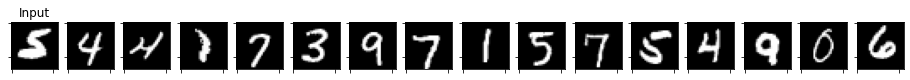

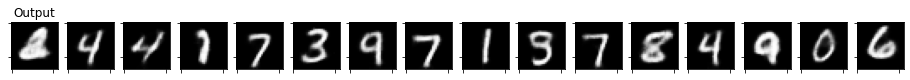

train_mse[46] = 0.022501748673459318
train_kld[46] = 4598.827573346077
train_loss[46] = 0.027100576222576993
test_mse[46] = 0.022432142589241266
test_kld[46] = 4559.944651794433
test_loss[46] = 0.026992087112739684



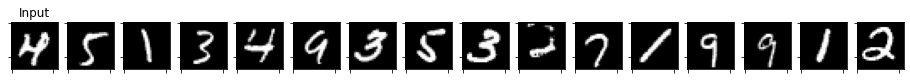

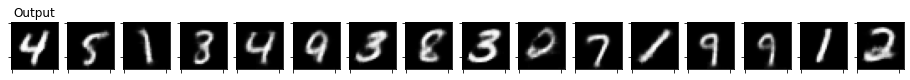

train_mse[47] = 0.022467606419578512
train_kld[47] = 4596.3403980011635
train_loss[47] = 0.027063946782591494
test_mse[47] = 0.02214370733126998
test_kld[47] = 4474.763894653321
test_loss[47] = 0.0266184713691473



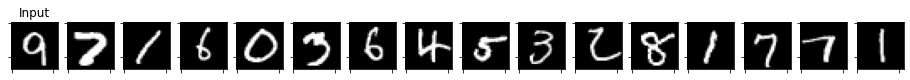

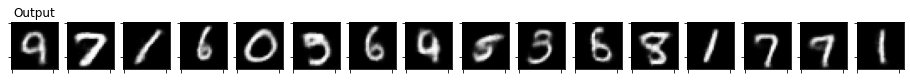

train_mse[48] = 0.022395115234750382
train_kld[48] = 4592.290899788065
train_loss[48] = 0.02698740617550434
test_mse[48] = 0.022121585393324494
test_kld[48] = 4523.345436859131
test_loss[48] = 0.026644930895417928



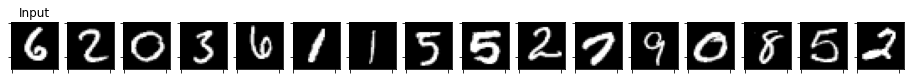

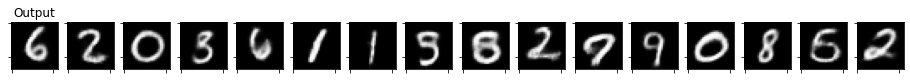

train_mse[49] = 0.022316178560574003
train_kld[49] = 4598.332627576463
train_loss[49] = 0.026914511232617053
test_mse[49] = 0.02202968755736947
test_kld[49] = 4552.229556274414
test_loss[49] = 0.026581917284056546



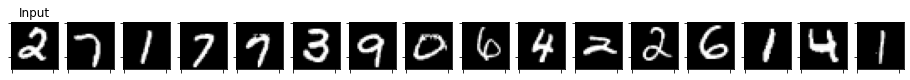

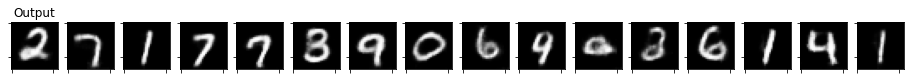

train_mse[50] = 0.022314527900295054
train_kld[50] = 4604.180938850565
train_loss[50] = 0.026918708834242314
test_mse[50] = 0.02226386168040335
test_kld[50] = 4531.484401702881
test_loss[50] = 0.02679534596391022



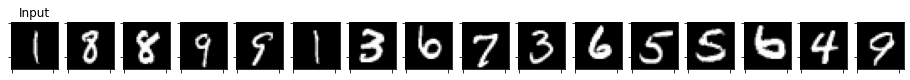

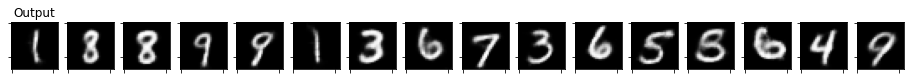

train_mse[51] = 0.022269391434940885
train_kld[51] = 4597.939539872839
train_loss[51] = 0.02686733089862986
test_mse[51] = 0.021861903415992857
test_kld[51] = 4476.52816619873
test_loss[51] = 0.026338431565091015



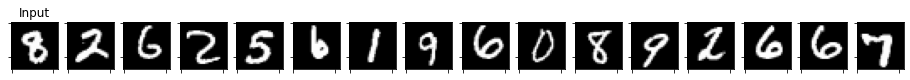

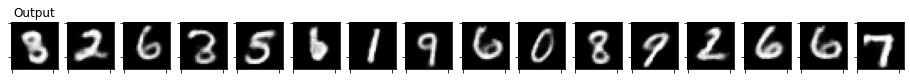

train_mse[52] = 0.022188396062305632
train_kld[52] = 4603.913460459607
train_loss[52] = 0.026792309520409462
test_mse[52] = 0.021798628382384777
test_kld[52] = 4591.751704406738
test_loss[52] = 0.026390380086377264



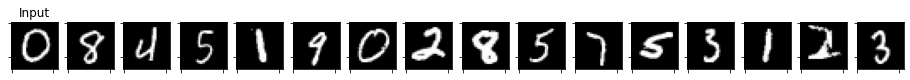

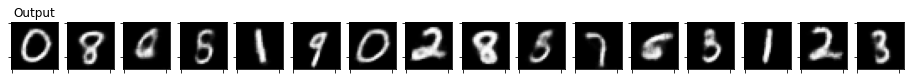

train_mse[53] = 0.022130308086250692
train_kld[53] = 4607.662060546875
train_loss[53] = 0.026737970089975825
test_mse[53] = 0.021743816044181585
test_kld[53] = 4561.400944519043
test_loss[53] = 0.0263052168302238



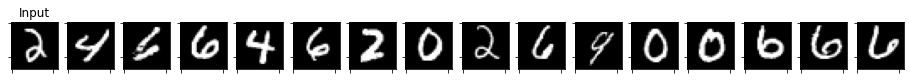

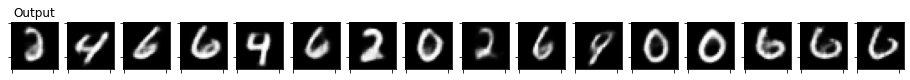

train_mse[54] = 0.022136069723266236
train_kld[54] = 4608.401468479887
train_loss[54] = 0.026744471197115614
test_mse[54] = 0.02203967929817736
test_kld[54] = 4554.489645385742
test_loss[54] = 0.02659416920505464



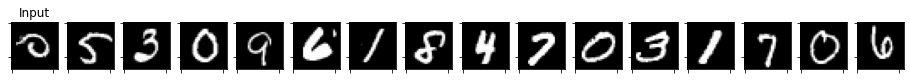

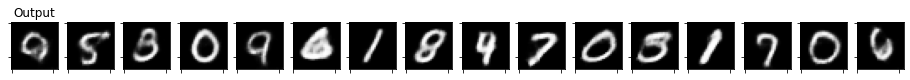

train_mse[55] = 0.022073448948720667
train_kld[55] = 4606.158072743518
train_loss[55] = 0.026679607013121564
test_mse[55] = 0.02168138069100678
test_kld[55] = 4610.400148773193
test_loss[55] = 0.02629178068600595



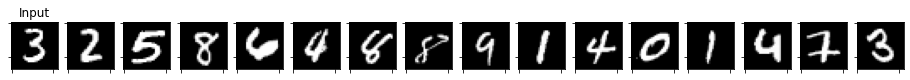

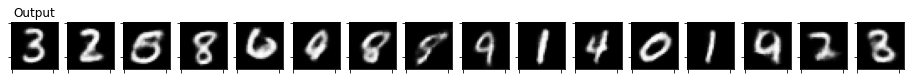

train_mse[56] = 0.02202019361739463
train_kld[56] = 4611.476229014295
train_loss[56] = 0.026631669787333365
test_mse[56] = 0.0217423050198704
test_kld[56] = 4597.804650878907
test_loss[56] = 0.026340109622105957



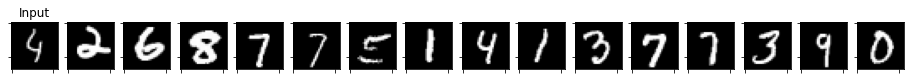

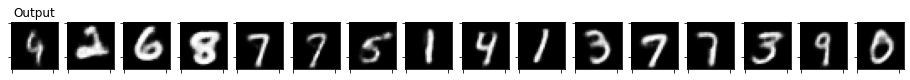

train_mse[57] = 0.02199388251025626
train_kld[57] = 4610.26090113863
train_loss[57] = 0.026604143387459693
test_mse[57] = 0.021478565596044063
test_kld[57] = 4627.443702697754
test_loss[57] = 0.026106009306386114



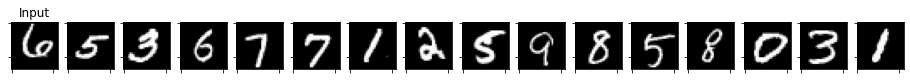

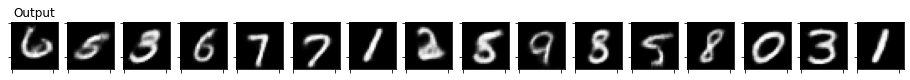

train_mse[58] = 0.021925712590839
train_kld[58] = 4614.193090300864
train_loss[58] = 0.026539905630844705
test_mse[58] = 0.021799699822440743
test_kld[58] = 4624.699955749512
test_loss[58] = 0.026424399809911847



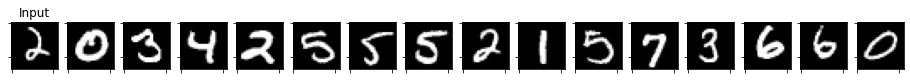

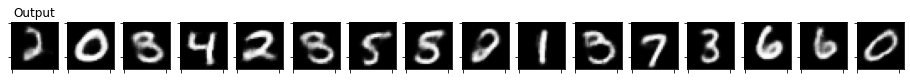

train_mse[59] = 0.021912204402875394
train_kld[59] = 4613.728610684009
train_loss[59] = 0.026525932986368524
test_mse[59] = 0.021828044764697553
test_kld[59] = 4537.15380935669
test_loss[59] = 0.026365198707208038



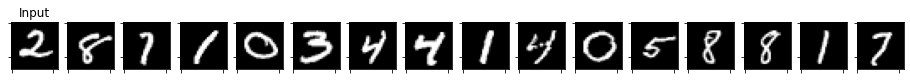

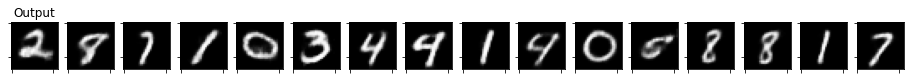

train_mse[60] = 0.02187521588453587
train_kld[60] = 4610.537956594913
train_loss[60] = 0.026485753867854463
test_mse[60] = 0.021605891501531006
test_kld[60] = 4615.402524566651
test_loss[60] = 0.026221294049173595



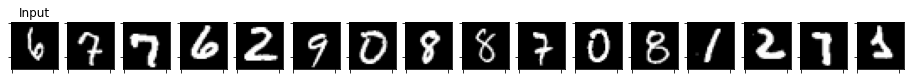

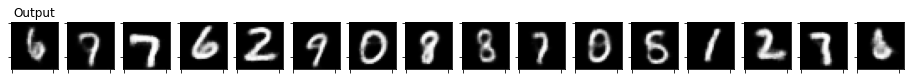

train_mse[61] = 0.02183325287509472
train_kld[61] = 4609.3045093292885
train_loss[61] = 0.02644255739101704
test_mse[61] = 0.021404931042343377
test_kld[61] = 4574.8341506958
test_loss[61] = 0.02597976508550346



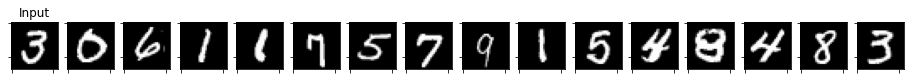

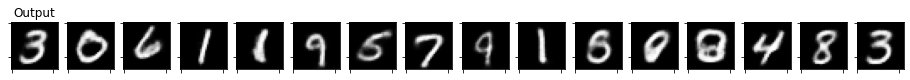

train_mse[62] = 0.02179919477314391
train_kld[62] = 4617.324156416224
train_loss[62] = 0.02641651892757162
test_mse[62] = 0.021518202032893896
test_kld[62] = 4584.765193939209
test_loss[62] = 0.026102967280894517



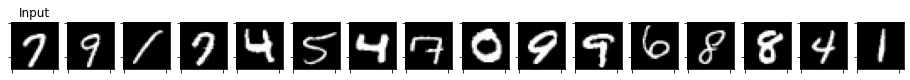

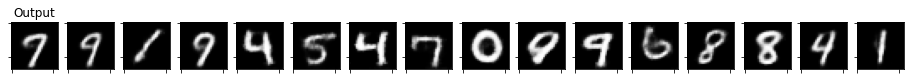

train_mse[63] = 0.021780576144761227
train_kld[63] = 4617.428030979887
train_loss[63] = 0.02639800417137907
test_mse[63] = 0.021588382543995976
test_kld[63] = 4571.436965179443
test_loss[63] = 0.02615981954149902



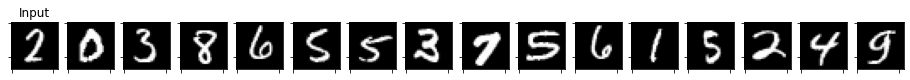

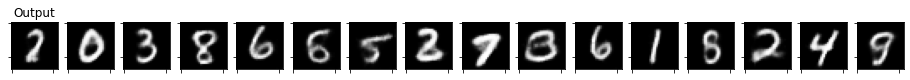

train_mse[64] = 0.021736411409492187
train_kld[64] = 4619.988718105884
train_loss[64] = 0.02635640011347355
test_mse[64] = 0.021485637966543437
test_kld[64] = 4543.772434234619
test_loss[64] = 0.026029410446062683



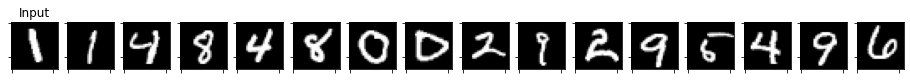

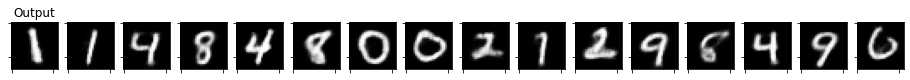

train_mse[65] = 0.021694402103411392
train_kld[65] = 4618.5225627493355
train_loss[65] = 0.026312924675801968
test_mse[65] = 0.02124129580333829
test_kld[65] = 4583.110385894775
test_loss[65] = 0.025824406230822206



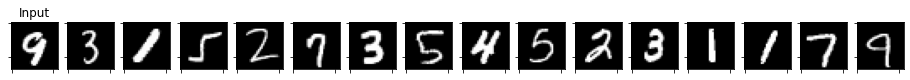

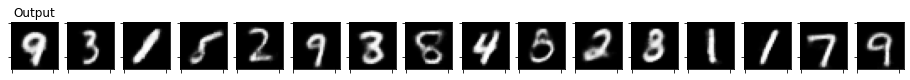

train_mse[66] = 0.021649944179869714
train_kld[66] = 4617.174759495512
train_loss[66] = 0.026267118950156456
test_mse[66] = 0.021516475547105073
test_kld[66] = 4539.797239685058
test_loss[66] = 0.026056272769346835



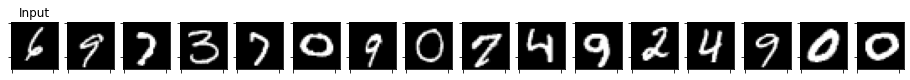

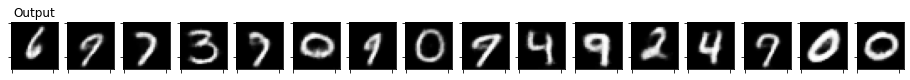

train_mse[67] = 0.021621408099506762
train_kld[67] = 4616.208216630652
train_loss[67] = 0.026237616363040943
test_mse[67] = 0.02125910217873752
test_kld[67] = 4549.275493621826
test_loss[67] = 0.025808377796784042



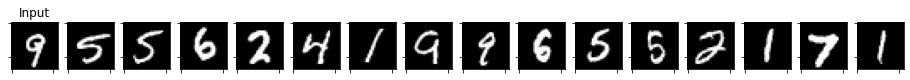

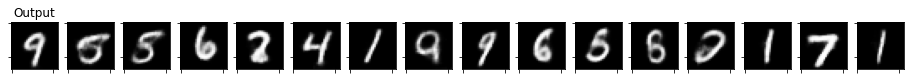

train_mse[68] = 0.02161027801797745
train_kld[68] = 4617.888699925199
train_loss[68] = 0.026228166728260668
test_mse[68] = 0.021538154734298588
test_kld[68] = 4549.4465606689455
test_loss[68] = 0.02608760125003755



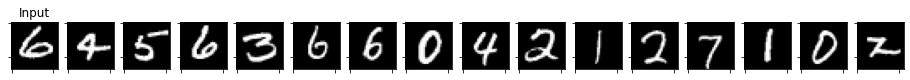

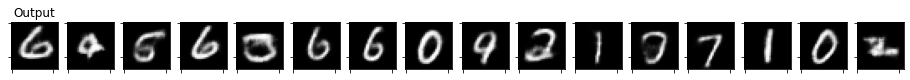

train_mse[69] = 0.021580065858173878
train_kld[69] = 4626.262834005153
train_loss[69] = 0.026206328672297458
test_mse[69] = 0.021377626014873384
test_kld[69] = 4579.210385131836
test_loss[69] = 0.025956836296245456



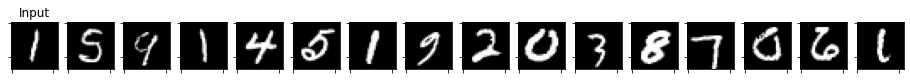

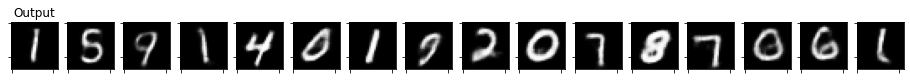

train_mse[70] = 0.021553654612061827
train_kld[70] = 4618.427706844249
train_loss[70] = 0.02617208235599893
test_mse[70] = 0.02130828145891428
test_kld[70] = 4574.38501586914
test_loss[70] = 0.025882666651159524



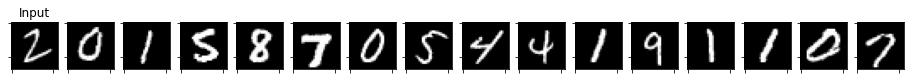

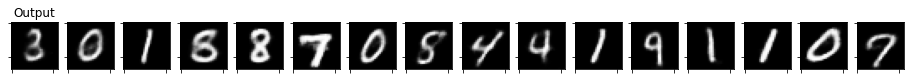

train_mse[71] = 0.021514522926287447
train_kld[71] = 4624.219968105885
train_loss[71] = 0.026138742918029746
test_mse[71] = 0.02128420271910727
test_kld[71] = 4562.235187530518
test_loss[71] = 0.025846437783911824



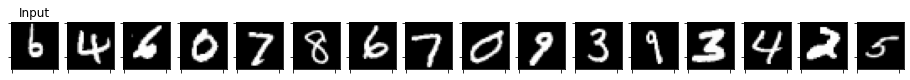

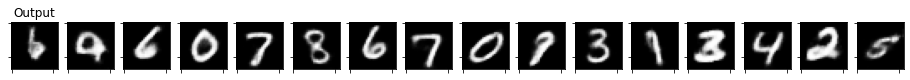

train_mse[72] = 0.0214965765146499
train_kld[72] = 4625.43244421127
train_loss[72] = 0.026122008914009055
test_mse[72] = 0.021088844770565628
test_kld[72] = 4591.893962860107
test_loss[72] = 0.025680738687515258



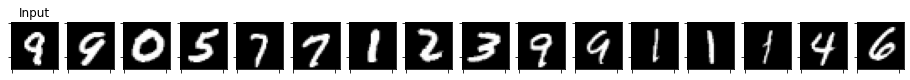

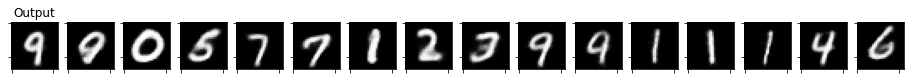

train_mse[73] = 0.021468255668878555
train_kld[73] = 4628.259346949801
train_loss[73] = 0.026096515024596072
test_mse[73] = 0.02122764941304922
test_kld[73] = 4627.178213500976
test_loss[73] = 0.025854827463626863



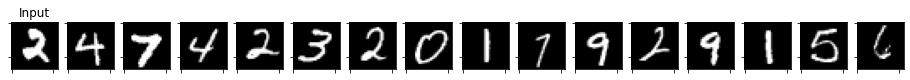

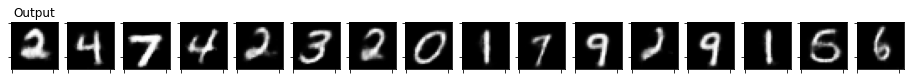

train_mse[74] = 0.021419869862655375
train_kld[74] = 4623.967594227893
train_loss[74] = 0.02604383743823843
test_mse[74] = 0.021157967578619718
test_kld[74] = 4570.861894226075
test_loss[74] = 0.025728829530999066



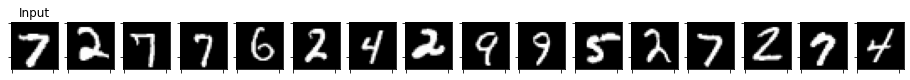

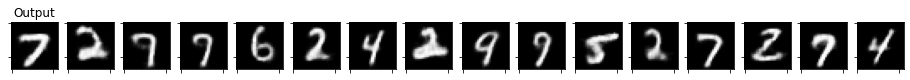

train_mse[75] = 0.02139517202814843
train_kld[75] = 4626.056164291057
train_loss[75] = 0.02602122813621734
test_mse[75] = 0.020998850464820862
test_kld[75] = 4591.624657440186
test_loss[75] = 0.0255904751829803



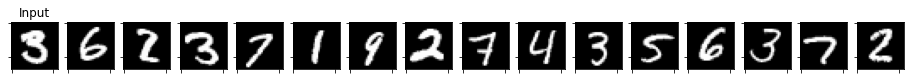

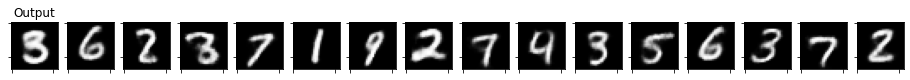

train_mse[76] = 0.021365073180579123
train_kld[76] = 4632.922081740359
train_loss[76] = 0.02599799523645259
test_mse[76] = 0.021090118540450932
test_kld[76] = 4605.234474182129
test_loss[76] = 0.025695353141054512



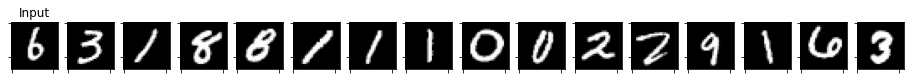

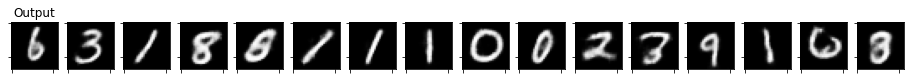

train_mse[77] = 0.021318743742526847
train_kld[77] = 4635.644247631317
train_loss[77] = 0.02595438797106134
test_mse[77] = 0.02091277902945876
test_kld[77] = 4593.388131713868
test_loss[77] = 0.025506167160347103



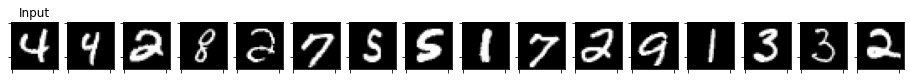

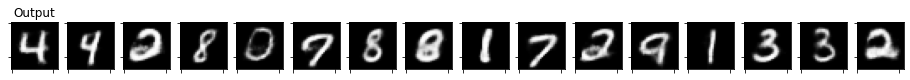

train_mse[78] = 0.021305762437429834
train_kld[78] = 4633.931314931017
train_loss[78] = 0.0259396937457805
test_mse[78] = 0.021170093957334758
test_kld[78] = 4541.011531066894
test_loss[78] = 0.02571110539138317



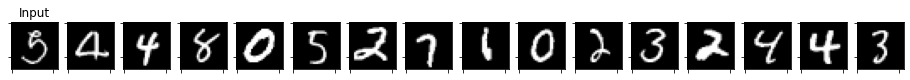

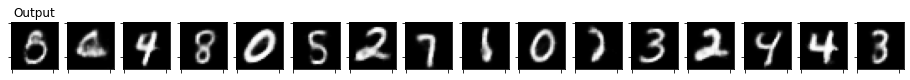

train_mse[79] = 0.02128434730495544
train_kld[79] = 4638.144130236037
train_loss[79] = 0.025922491314246298
test_mse[79] = 0.020865146070718765
test_kld[79] = 4545.269661712647
test_loss[79] = 0.025410415744408964



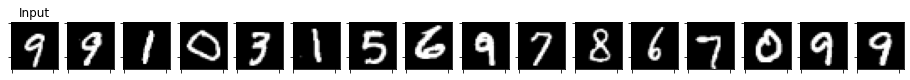

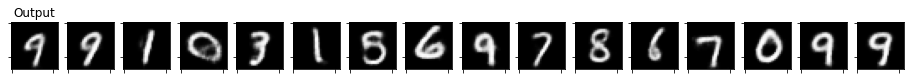

train_mse[80] = 0.021261205302273975
train_kld[80] = 4637.522446392952
train_loss[80] = 0.02589872771913701
test_mse[80] = 0.021025048615410925
test_kld[80] = 4608.4633163452145
test_loss[80] = 0.025633511831983924



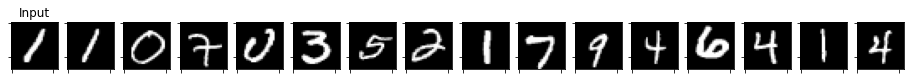

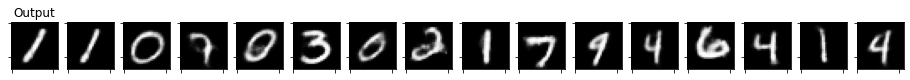

train_mse[81] = 0.021229622299049764
train_kld[81] = 4638.338083859708
train_loss[81] = 0.02586796038803902
test_mse[81] = 0.020923433592543006
test_kld[81] = 4587.26010055542
test_loss[81] = 0.02551069357432425



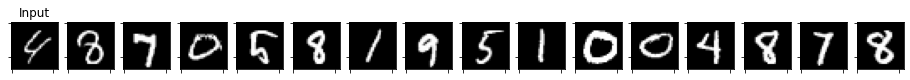

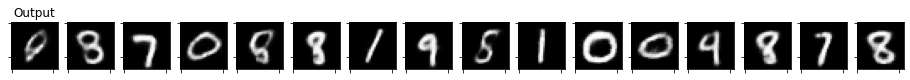

train_mse[82] = 0.02119360108800391
train_kld[82] = 4634.315664997506
train_loss[82] = 0.02582791671156883
test_mse[82] = 0.02077300138771534
test_kld[82] = 4667.791494750976
test_loss[82] = 0.02544079292565584



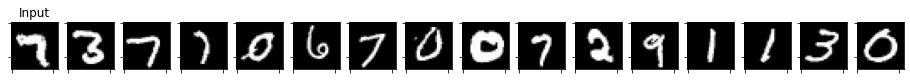

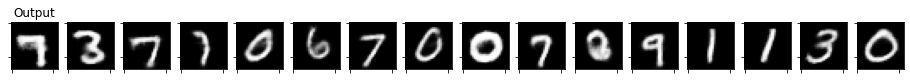

train_mse[83] = 0.02115159349397142
train_kld[83] = 4648.936116709608
train_loss[83] = 0.02580052967718307
test_mse[83] = 0.020898957876488565
test_kld[83] = 4595.369951629638
test_loss[83] = 0.025494327815249563



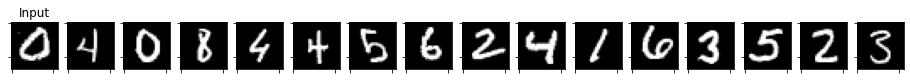

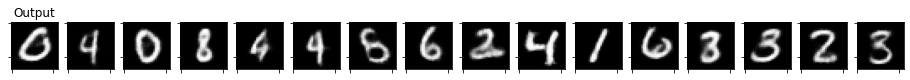

train_mse[84] = 0.021153880671617834
train_kld[84] = 4640.213656811004
train_loss[84] = 0.025794094317453973
test_mse[84] = 0.021070001926273108
test_kld[84] = 4550.911873626709
test_loss[84] = 0.0256209138315171



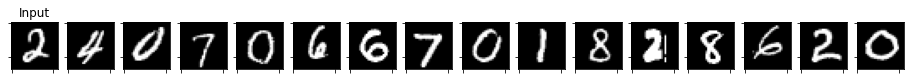

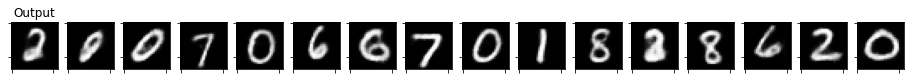

train_mse[85] = 0.02111821992600218
train_kld[85] = 4646.821798121676
train_loss[85] = 0.025765041737480367
test_mse[85] = 0.020632914220914244
test_kld[85] = 4574.648379516601
test_loss[85] = 0.025207562488503754



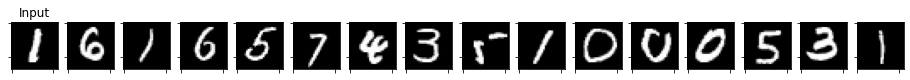

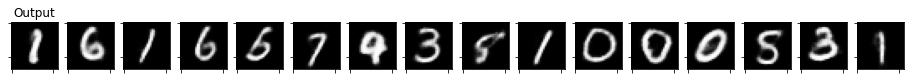

train_mse[86] = 0.02110150122737631
train_kld[86] = 4645.332841589096
train_loss[86] = 0.0257468340720268
test_mse[86] = 0.020812683505937457
test_kld[86] = 4621.546806335449
test_loss[86] = 0.025434230314567687



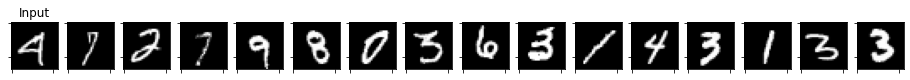

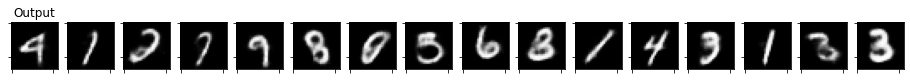

train_mse[87] = 0.021080994431642776
train_kld[87] = 4647.015027115192
train_loss[87] = 0.02572800945886906
test_mse[87] = 0.020825643138960005
test_kld[87] = 4614.2123748779295
test_loss[87] = 0.02543985564261675



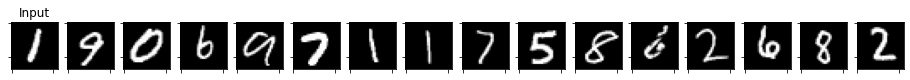

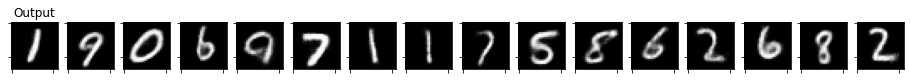

train_mse[88] = 0.021045407716264116
train_kld[88] = 4645.155237595579
train_loss[88] = 0.025690562935902717
test_mse[88] = 0.020609699841588735
test_kld[88] = 4648.684474945068
test_loss[88] = 0.02525838417932391



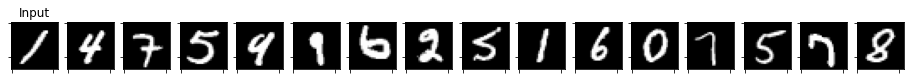

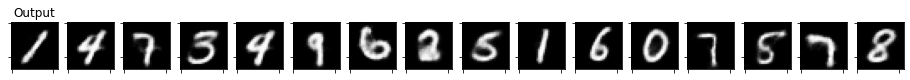

train_mse[89] = 0.021021644723542194
train_kld[89] = 4651.111140604222
train_loss[89] = 0.02567275585012233
test_mse[89] = 0.020662272302433848
test_kld[89] = 4616.883284759521
test_loss[89] = 0.025279155699536204



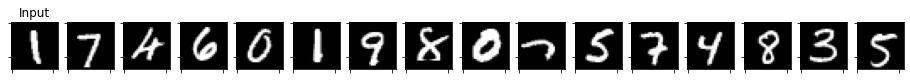

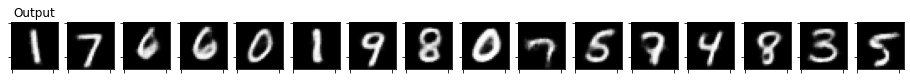

train_mse[90] = 0.020993244996730318
train_kld[90] = 4650.99491356383
train_loss[90] = 0.02564423994181004
test_mse[90] = 0.020739410305395722
test_kld[90] = 4550.785537719727
test_loss[90] = 0.02529019587673247



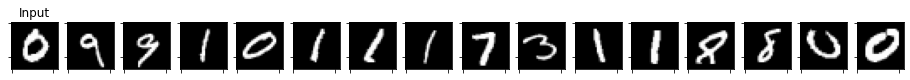

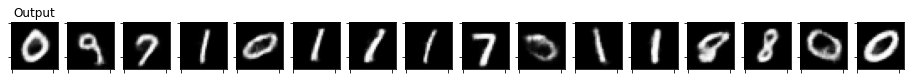

train_mse[91] = 0.02098955378887501
train_kld[91] = 4650.71692258145
train_loss[91] = 0.025640270692553927
test_mse[91] = 0.020590072916820645
test_kld[91] = 4626.051932525635
test_loss[91] = 0.025216124765574933



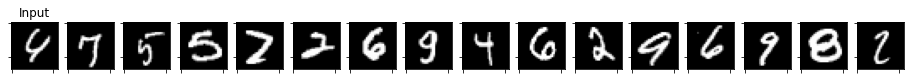

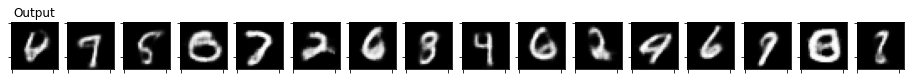

train_mse[92] = 0.020967723936476605
train_kld[92] = 4650.451687687001
train_loss[92] = 0.02561817565496932
test_mse[92] = 0.020701183984056116
test_kld[92] = 4656.933280181885
test_loss[92] = 0.025358117232099176



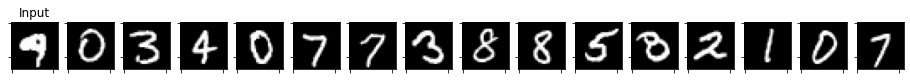

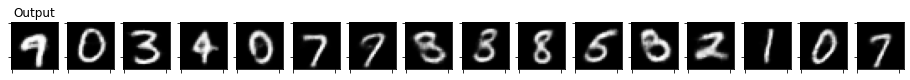

train_mse[93] = 0.020932219819502627
train_kld[93] = 4658.493335999834
train_loss[93] = 0.025590713163639638
test_mse[93] = 0.020871318038553
test_kld[93] = 4626.44725189209
test_loss[93] = 0.025497765373438598



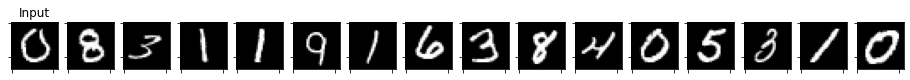

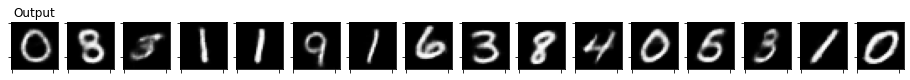

train_mse[94] = 0.020925511364290054
train_kld[94] = 4664.397747672872
train_loss[94] = 0.025589909095396386
test_mse[94] = 0.02041817521676421
test_kld[94] = 4641.452338409424
test_loss[94] = 0.025059627695009114



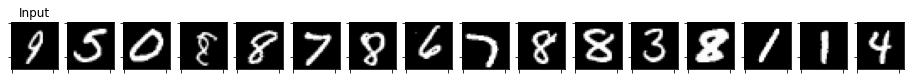

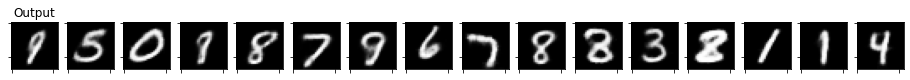

train_mse[95] = 0.020880502882473014
train_kld[95] = 4663.558072224069
train_loss[95] = 0.025544060901441474
test_mse[95] = 0.020769927417859435
test_kld[95] = 4646.57052154541
test_loss[95] = 0.02541649783961475



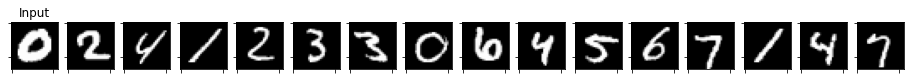

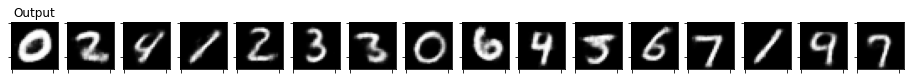

train_mse[96] = 0.02085368944767942
train_kld[96] = 4658.341980240193
train_loss[96] = 0.025512031481621112
test_mse[96] = 0.020737909851595758
test_kld[96] = 4607.666969299316
test_loss[96] = 0.025345576787367464



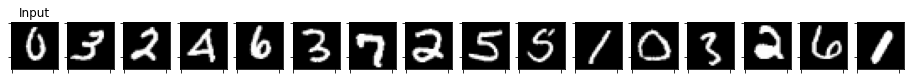

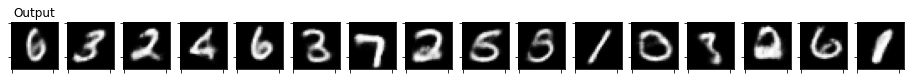

train_mse[97] = 0.020850139888043098
train_kld[97] = 4660.929051695479
train_loss[97] = 0.025511068977574086
test_mse[97] = 0.020542695978656413
test_kld[97] = 4603.956281280518
test_loss[97] = 0.025146652199327945



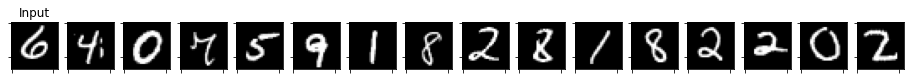

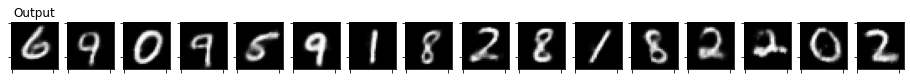

train_mse[98] = 0.020820866033751915
train_kld[98] = 4657.775723591257
train_loss[98] = 0.025478641783937495
test_mse[98] = 0.020499854115769267
test_kld[98] = 4623.207650756836
test_loss[98] = 0.02512306170538068



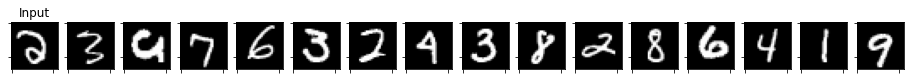

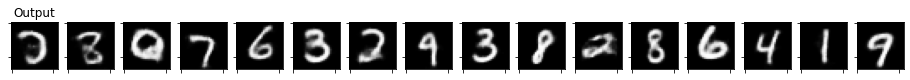

train_mse[99] = 0.020787760472678125
train_kld[99] = 4664.190426051363
train_loss[99] = 0.02545195091912087
test_mse[99] = 0.020367012824863195
test_kld[99] = 4583.9700004577635
test_loss[99] = 0.024950982816517354



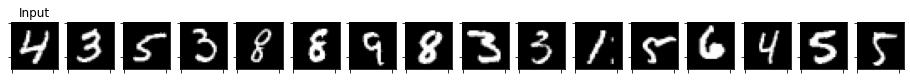

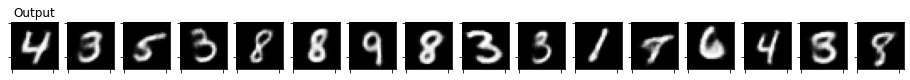

train_mse[100] = 0.02078524594928356
train_kld[100] = 4671.171077647107
train_loss[100] = 0.025456417034915153
test_mse[100] = 0.020683181751519442
test_kld[100] = 4611.482066345215
test_loss[100] = 0.025294663663953543



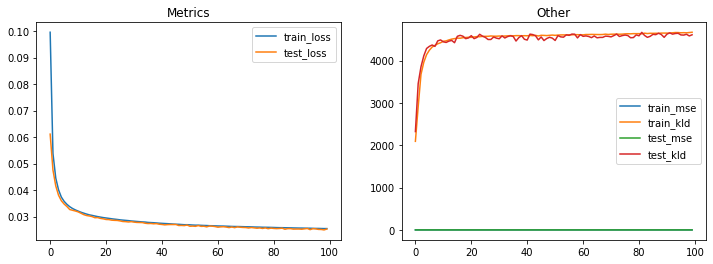

In [3]:
from training import train, MetricsCollector
from vae import ElboLoss

vae_elbo, metrics_elbo = train(
    train_ds, test_ds, 
    VariationalAutoencoder(dim=8), ElboLoss(beta=1e-6),
    epochs=100, lr=1e-3, batch=256,
    metrics=MetricsCollector("mse", "kld"),
)

In [4]:
from training import save_model
save_model('models/vae_elbo', vae_elbo, metrics_elbo)

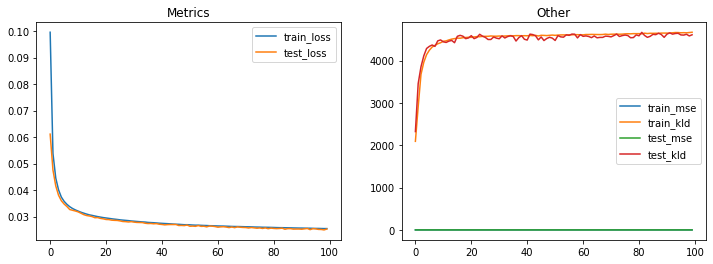

In [1]:
from training import load_model
from vae import VariationalAutoencoder
vae_elbo, metrics_elbo = load_model('models/vae_elbo', VariationalAutoencoder(dim=8))
metrics_elbo.plot()

## Generation

In [3]:
from dataset import load_mnist

test_data, labels = load_mnist(train=False)

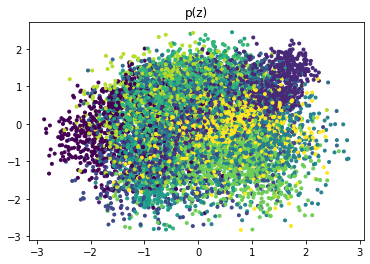

In [4]:
from training import embedding
from plotting import plot_embedding_space

embeddings_elbo = embedding(lambda x: vae_elbo._encoder(x)[1], test_data)
plot_embedding_space(embeddings_elbo, labels, "p(z)")

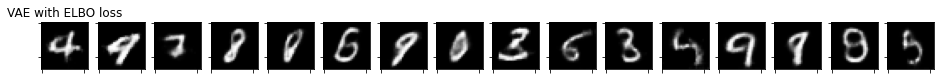

In [9]:
from training import generate_images
from plotting import plot_images

images = generate_images(vae_elbo._encoder, vae_elbo._decoder)
plot_images(images, "VAE with ELBO loss")

## $\beta$-schedule

To reduce the posterior collapse/KL-vanishing effects, one possibility is to use __variable $\beta$ values__.

Some $\beta$-schedules are compared [here](https://www.microsoft.com/en-us/research/blog/less-pain-more-gain-a-simple-method-for-vae-training-with-less-of-that-kl-vanishing-agony/).